### Imports


In [1]:
import sys
sys.path.insert(0, '../Continuous-Weight-Balancing')
sys.path.insert(0, '../utils')
from weight_balancing import continuous_weight
from util import plot_cont_var, assess_sklearn_regressor

import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from pathlib import *
from matplotlib import pyplot as plt
from scipy import stats
from math import pi
from pprint import pprint
## Sklearn models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

## Keras imports
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


## Bokeh plotting
from bokeh.io import output_notebook
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.transform import cumsum
from bokeh.palettes import Spectral6
from bokeh.models import ColumnDataSource
from bokeh.layouts import gridplot

Using TensorFlow backend.


In [2]:
#### Constants ####

SEED = 42
N_ESTIMATORS = 200 # Random Forest

In [3]:
output_notebook()

Loading BokehJS ...

## Understand the California Housing dataset 

In [4]:
df = pd.read_csv('../data/cali_housing/data.csv')
df.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


Each row contains eight features of a california housing block. Let's have a look at what each of these columns means:

1. **MedInc** -> Median income of the residents in this block.
2. **HouseAge** -> Median house age of homes in this block.
3. **AveRooms** -> Average number of rooms per house.
4. **AveBedrms** -> Average number of bedrooms per house.
5. **Population** -> Population of the block.
6. **AveOccup** -> Average occupancy of homes in this block.
7. **Latitude** -> Latitude of the block.
8. **Longitude** -> Longitude of the block.
9. **target** -> The average house price in this block

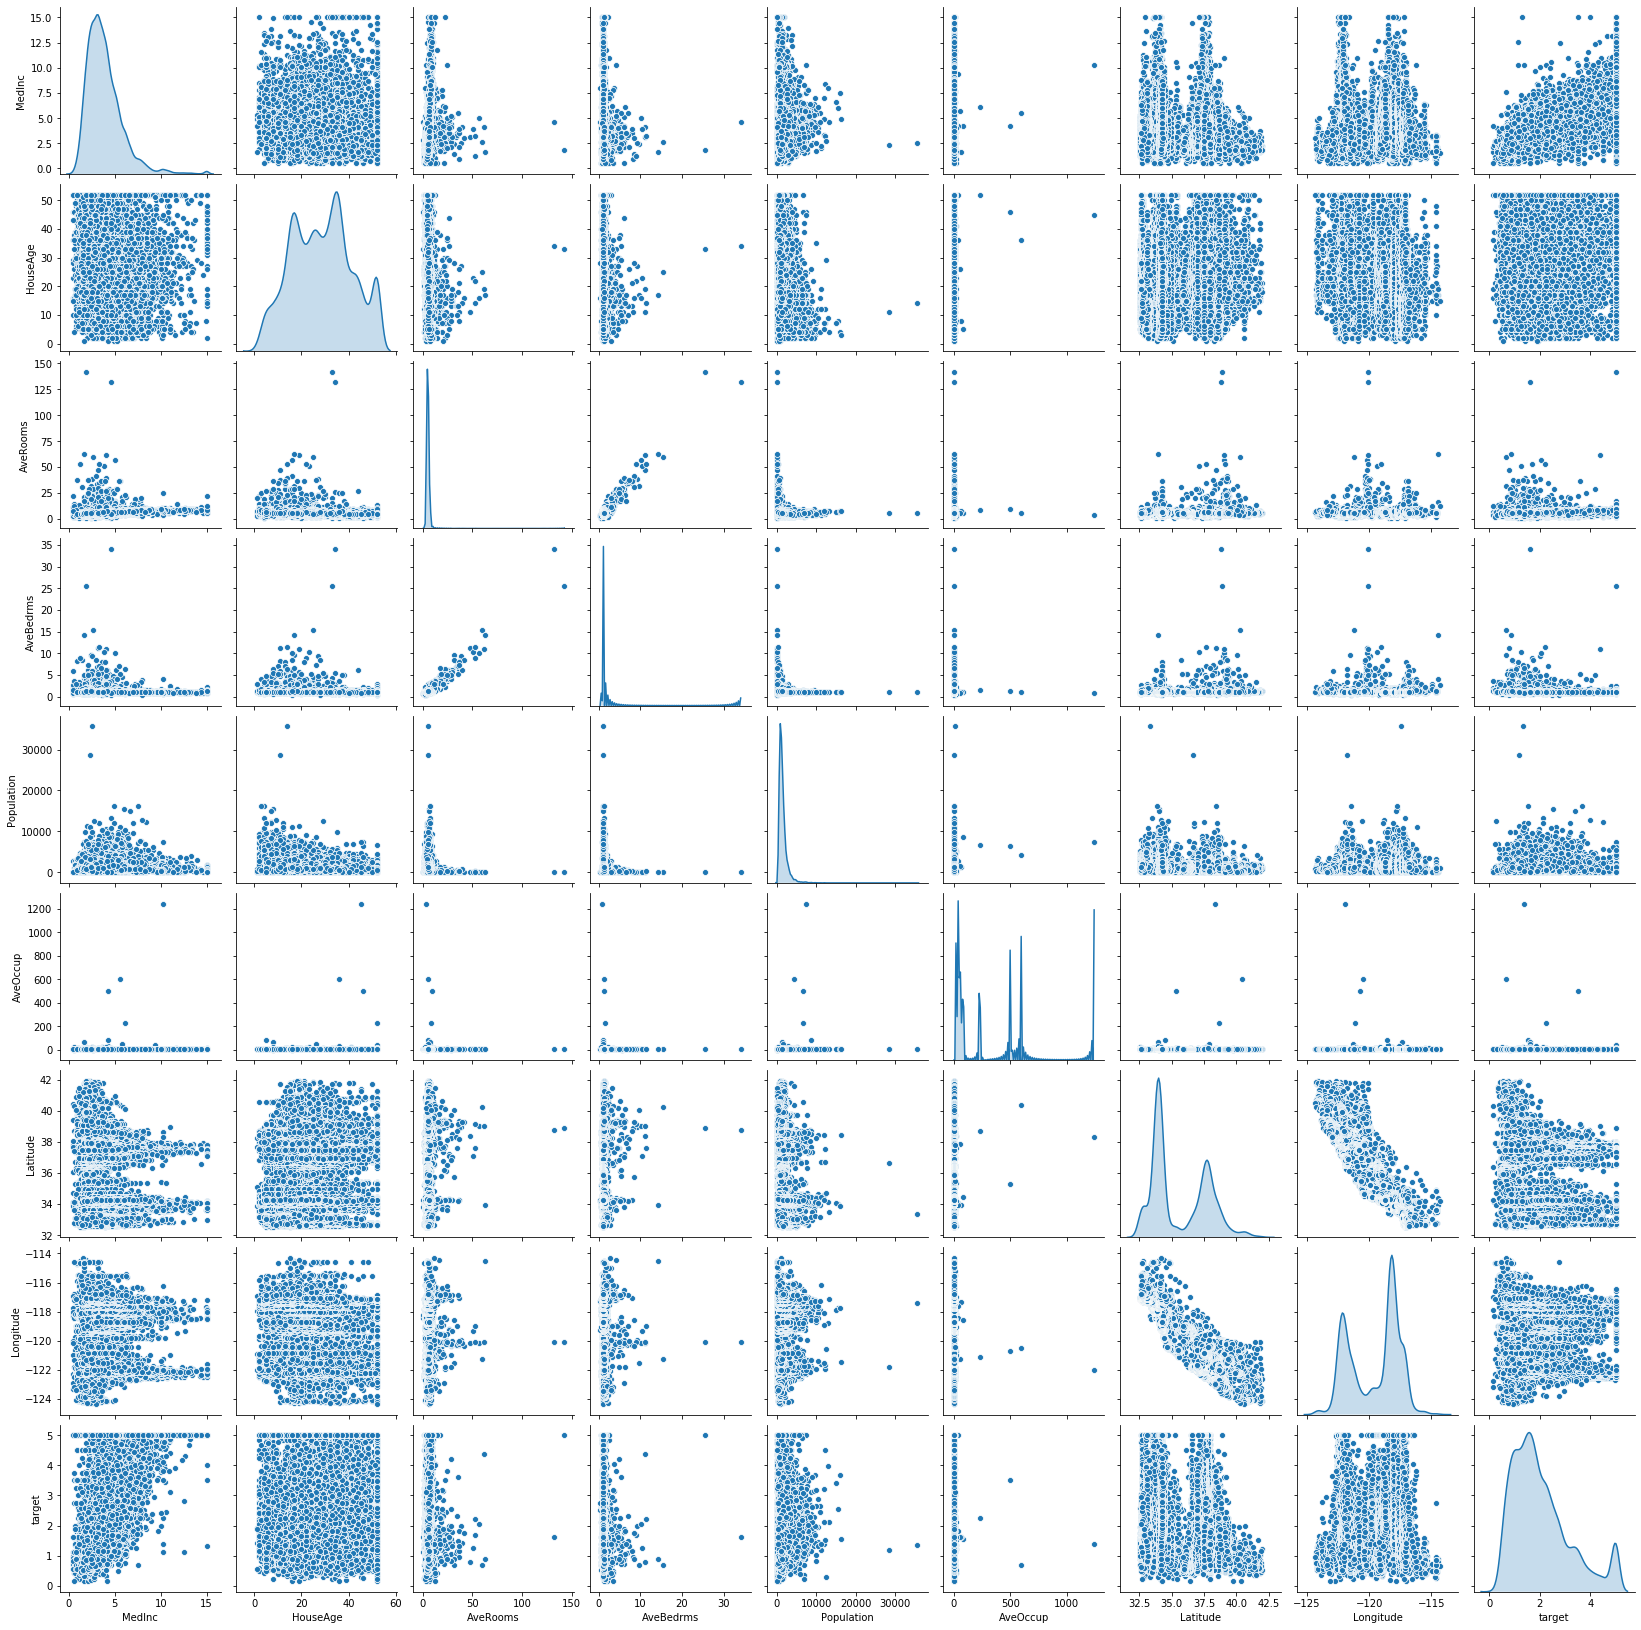

In [5]:
sns.pairplot(df, diag_kind="kde")

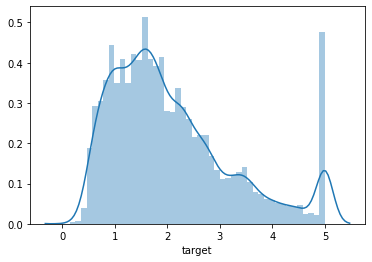

In [6]:
sns.distplot(df.target)

## Use-case



We see from the plot above that the dataset is skewed right. Sklearn has done some preprocessing by default, which causes the clipping at 5 (See https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset). Suppose we are interested in accurately predicting median home prices of expensive areas - we're a high-end land developer. 


### Loading dataset + weight traits

We assume all data is mean-normalized beforehand.

In [7]:
data_dir = Path('../data/cali_housing')
X_train = np.load(data_dir / 'X_train.npy')
y_train = np.load(data_dir / 'y_train.npy')
X_val = np.load(data_dir / 'X_val.npy')
y_val = np.load(data_dir / 'y_val.npy')
X_test = np.load(data_dir / 'X_test.npy')
y_test = np.load(data_dir / 'y_test.npy')


traits_train = np.load(data_dir / 'traits_train.npy')
traits_val = np.load(data_dir / 'traits_val.npy')
traits_test = np.load(data_dir / 'traits_test.npy')

# Greater than a housing price of 2
CUTOFF = 2
X_above = X_val[traits_val > CUTOFF]
y_above = y_val[traits_val > CUTOFF]

print(X_train.shape, X_val.shape, X_test.shape, X_above.shape)

(16512, 8) (2064, 8) (2064, 8) (896, 8)


In [8]:
traits_train.min(), traits_val.min(), traits_test.min(), traits_train.max(), traits_val.max(), traits_test.max()

(0.14999, 0.14999, 0.25, 5.00001, 5.00001, 5.00001)

### Generating weights on the fly

In [9]:
## Let's target a normal distribution centered at 3
target = stats.norm(loc = 3, scale = 1)

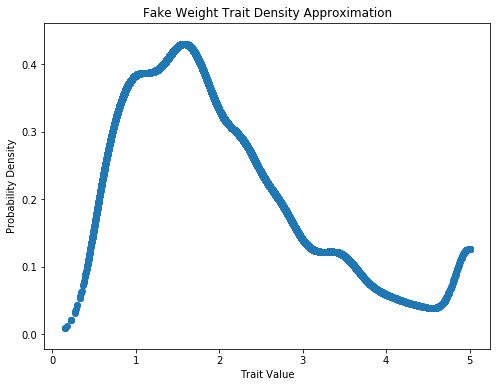

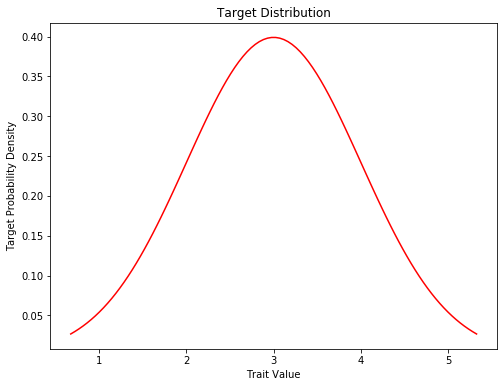

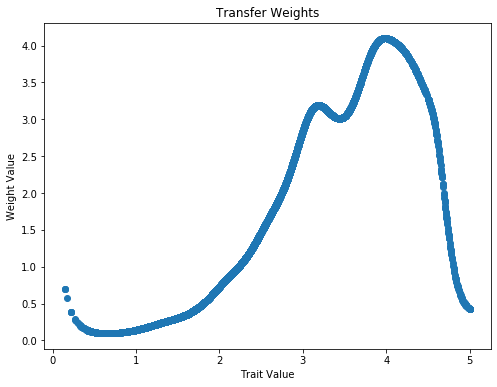

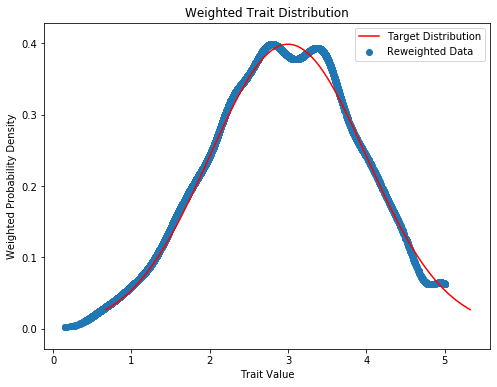

In [10]:
wts_tr = continuous_weight(traits_train, target, addl_trait = None, clipping = None, verbose = True)

We notice weight trait isn't perfectly normal, but we're pretty close.

### Let's make a pretty comparison graph

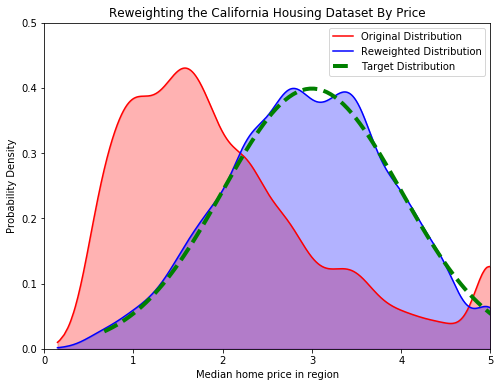

In [25]:
def comparison_graph(trait, target, weights):
    #Sort the trait and weights
    tmp = sorted(zip(trait,weights))
    trait = [item[0] for item in tmp]
    weights = [item[1] for item in tmp]
    
    source_kde = stats.gaussian_kde(trait)
    estimate = source_kde.evaluate(trait)
    
    plt.figure(figsize=(8, 6))
    plt.title("Reweighting the California Housing Dataset By Price")
    plt.xlabel("Median home price in region")
    plt.ylabel("Probability Density")
    #Plot original
    plt.plot(trait, estimate, "r", label = "Original Distribution")
    plt.fill_between(trait, estimate, np.zeros(len(trait)), color = "r", alpha=0.3)
    
    #Plot weighted source
    weighted_kde = stats.gaussian_kde(trait, weights = weights)
    weighted_estimate = weighted_kde.evaluate(trait)
    plt.plot(trait, weighted_estimate, "b", label="Reweighted Distribution")
    plt.fill_between(trait, weighted_estimate, np.zeros(len(trait)), color = "b", alpha=0.3)

    #Plot target
    x = np.linspace(target.ppf(0.01),
                target.ppf(0.99), 100)
    plt.plot(x, target.pdf(x), "g--", label = "Target Distribution", linewidth = 4)
    
    plt.legend()
    plt.xlim([0, 5])
    plt.ylim([0, 0.5])
    plt.show()
    
comparison_graph(traits_train, target, wts_tr)

# Part-1: Does CWB improve performance over uniform sampling? 

## Random Forest

#### Without sample balancing on the entire val set


In [11]:
clf_unbalanced = RandomForestRegressor(n_estimators=100, random_state=SEED).fit(X_train, y_train, sample_weight=None)
r2, mse = assess_sklearn_regressor(clf_unbalanced, X_val, y_val)
print("R2 value on unbalanced data: ", r2)
print("MSE value on unbalanced data: ", mse)

R2 value on unbalanced data:  0.8021135499160041
MSE value on unbalanced data:  0.26452538061895847


#### Now training using continuous sample-weights as a function of the target

In [12]:
clf_balanced = RandomForestRegressor(n_estimators=100, random_state=SEED).fit(X_train, y_train, sample_weight=wts_tr)
r2, mse = assess_sklearn_regressor(clf_balanced, X_val, y_val)
print("R2 value on weighted data: ", r2)
print("MSE value on weighted data: ", mse)

R2 value on weighted data:  0.8021135499160041
MSE value on weighted data:  0.26452538061895847


### Evaluating on prices above 2

In [14]:
## X_above & y_above defined at start of notebook
r2, mse = assess_sklearn_regressor(clf_unbalanced, X_above, y_above)
print("R2 value on expensive house subset, with unbalanced model:", r2)
print("MSE value on expensive house subset, with unbalanced model:", mse)

r2, mse = assess_sklearn_regressor(clf_balanced, X_above, y_above)
print("R2 value on expensive house subset, with balanced model:", r2)
print("MSE value on expensive house subset, with balanced model:", mse)

R2 value on expensive house subset, with unbalanced model: 0.515613318800477
MSE value on expensive house subset, with unbalanced model: 0.43484338710206083
R2 value on expensive house subset, with balanced model: 0.5225816015938314
MSE value on expensive house subset, with balanced model: 0.4285878235001807


**Note**: Both models perform aboutthe same on the OOS set, but the model trained on balanced data outperforms on a dataset limiited to subjects < 60

## Linear Regression

#### Without sample balancing on the entire out-of-sample set


In [18]:
clf_unbalanced = LinearRegression().fit(X_train, y_train, sample_weight=None)
r2, mse = assess_sklearn_regressor(clf_unbalanced, X_val, y_val)
print("R2 value on unbalanced data: ", r2)
print("MSE value on unbalanced data: ", mse)

R2 value on unbalanced data:  0.5792673355756117
MSE value on unbalanced data:  0.562415810422842


#### Now training using continuous sample-weights as a function of age

In [19]:
clf_balanced = LinearRegression().fit(X_train, y_train, sample_weight=wts_tr)
r2, mse = assess_sklearn_regressor(clf_balanced, X_val, y_val)
print("R2 value on weighted data: ", r2)
print("MSE value on weighted data: ", mse)

R2 value on weighted data:  0.44197489564921777
MSE value on weighted data:  0.7459419432743809


### Evaluating on prices above 2


In [20]:
## X_above & y_above defined at start of notebook
r2, mse = assess_sklearn_regressor(clf_unbalanced, X_above, y_above)
print("R2 value on expensive house subset, with unbalanced model:", r2)
print("MSE value on expensive house subset, with unbalanced model:", mse)

r2, mse = assess_sklearn_regressor(clf_balanced, X_above, y_above)
print("R2 value on expensive house subset, with balanced model:", r2)
print("MSE value on expensive house subset, with balanced model:", mse)

R2 value on expensive house subset, with unbalanced model: 0.04763491755575977
MSE value on expensive house subset, with unbalanced model: 0.8549567407226115
R2 value on expensive house subset, with balanced model: 0.35007771534133614
MSE value on expensive house subset, with balanced model: 0.5834479323713524


The balanced model does much worse.

## Deep Neural Net

In [13]:
from tqdm import tqdm
def make_nn():
    model = Sequential()
    model.add(Dense(64, input_dim=8, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation=None))

    model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])
    return model

es = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=25, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, 
                       mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
callbacks = [es, lr]

args_dict = {'x': X_train,
             'y': y_train,
             'epochs': 100,
             'validation_data': (X_val, y_val),
             'verbose': 1,
             'batch_size': 16,
             'callbacks': callbacks
            }

class Ensemble: 
    def __init__(self, size=10):
        self.models = [make_nn() for _ in range(size)]
        
    def print_summary(self):
        self.models[0].summary()
    def fit(self, args_dict, sample_weight=None):
        for model in tqdm(self.models):
            model.fit(**args_dict, sample_weight=sample_weight)
    def validate(self, X, y):
        mean_pred = np.mean(np.array([model.predict(X) for model in self.models]), axis=0)
        return mean_squared_error(y, mean_pred), r2_score(y, mean_pred)
    

**Note**: Due to the variance in Neural Net performance as a result of the random seed, we train an _ensemble_ of 10 models for each data-balancing scheme and average out the predictions on the out-of-sample test

#### First training with unbalanced data

In [14]:
nn_unbalanced = Ensemble(10)
nn_unbalanced.print_summary()

nn_unbalanced.fit(args_dict)
mse, r2 = nn_unbalanced.validate(X_val, y_val)
print("Unbalanced MSE value: ", mse)
print("Unbalanced R2 value: ", r2)

  0%|          | 0/10 [00:00<?, ?it/s]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________
Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 266us/step - loss: 1.0425 - mse: 1.0425 - mae: 0.7156 - val_loss: 0.4826 - val_mse: 0.4826 - val_mae: 0.4812
Epoch 2/100
16512/16512 [=====

 10%|█         | 1/10 [03:59<35:58, 239.88s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 220us/step - loss: 0.9430 - mse: 0.9430 - mae: 0.6948 - val_loss: 0.4996 - val_mse: 0.4996 - val_mae: 0.4787
Epoch 2/100
16512/16512 [==============================] - 3s 201us/step - loss: 0.5198 - mse: 0.5198 - mae: 0.5158 - val_loss: 0.4372 - val_mse: 0.4372 - val_mae: 0.4557
Epoch 3/100
16512/16512 [==============================] - 3s 209us/step - loss: 0.4553 - mse: 0.4553 - mae: 0.4839 - val_loss: 0.4102 - val_mse: 0.4102 - val_mae: 0.4408
Epoch 4/100
16512/16512 [==============================] - 3s 203us/step - loss: 0.4380 - mse: 0.4380 - mae: 0.4742 - val_loss: 0.4027 - val_mse: 0.4027 - val_mae: 0.4310
Epoch 5/100
16512/16512 [==============================] - 3s 207us/step - loss: 0.4156 - mse: 0.4156 - mae: 0.4603 - val_loss: 0.3785 - val_mse: 0.3785 - val_mae: 0.4194
Epoch 6/100
16512/16512 [==============================] - 3s 208us/step - loss: 0.4180 - mse: 0

 20%|██        | 2/10 [07:46<31:27, 235.95s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 228us/step - loss: 1.0048 - mse: 1.0048 - mae: 0.7068 - val_loss: 0.4735 - val_mse: 0.4735 - val_mae: 0.4831
Epoch 2/100
16512/16512 [==============================] - 3s 201us/step - loss: 0.5432 - mse: 0.5432 - mae: 0.5222 - val_loss: 0.4251 - val_mse: 0.4251 - val_mae: 0.4558
Epoch 3/100
16512/16512 [==============================] - 3s 211us/step - loss: 0.4647 - mse: 0.4647 - mae: 0.4877 - val_loss: 0.4021 - val_mse: 0.4021 - val_mae: 0.4442
Epoch 4/100
16512/16512 [==============================] - 3s 202us/step - loss: 0.4325 - mse: 0.4325 - mae: 0.4711 - val_loss: 0.3967 - val_mse: 0.3967 - val_mae: 0.4414
Epoch 5/100
16512/16512 [==============================] - 3s 201us/step - loss: 0.4154 - mse: 0.4154 - mae: 0.4629 - val_loss: 0.3689 - val_mse: 0.3689 - val_mae: 0.4235
Epoch 6/100
16512/16512 [==============================] - 3s 210us/step - loss: 0.4072 - mse: 0

 30%|███       | 3/10 [10:40<25:21, 217.40s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 3s 209us/step - loss: 1.1437 - mse: 1.1437 - mae: 0.7335 - val_loss: 0.5072 - val_mse: 0.5072 - val_mae: 0.4985
Epoch 2/100
16512/16512 [==============================] - 3s 197us/step - loss: 0.5495 - mse: 0.5495 - mae: 0.5291 - val_loss: 0.4391 - val_mse: 0.4391 - val_mae: 0.4696
Epoch 3/100
16512/16512 [==============================] - 3s 199us/step - loss: 0.4760 - mse: 0.4760 - mae: 0.4942 - val_loss: 0.4168 - val_mse: 0.4168 - val_mae: 0.4624
Epoch 4/100
16512/16512 [==============================] - 3s 196us/step - loss: 0.4435 - mse: 0.4435 - mae: 0.4780 - val_loss: 0.3920 - val_mse: 0.3920 - val_mae: 0.4409
Epoch 5/100
16512/16512 [==============================] - 3s 199us/step - loss: 0.4282 - mse: 0.4282 - mae: 0.4674 - val_loss: 0.3883 - val_mse: 0.3883 - val_mae: 0.4294
Epoch 6/100
16512/16512 [==============================] - 3s 199us/step - loss: 0.4127 - mse: 0

 40%|████      | 4/10 [15:31<23:57, 239.53s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 3s 211us/step - loss: 1.0321 - mse: 1.0321 - mae: 0.7096 - val_loss: 0.5121 - val_mse: 0.5121 - val_mae: 0.5019
Epoch 2/100
16512/16512 [==============================] - 3s 199us/step - loss: 0.5564 - mse: 0.5564 - mae: 0.5360 - val_loss: 0.5104 - val_mse: 0.5104 - val_mae: 0.4811
Epoch 3/100
16512/16512 [==============================] - 3s 200us/step - loss: 0.4828 - mse: 0.4828 - mae: 0.4948 - val_loss: 0.5551 - val_mse: 0.5551 - val_mae: 0.4668
Epoch 4/100
16512/16512 [==============================] - 3s 201us/step - loss: 0.4637 - mse: 0.4637 - mae: 0.4820 - val_loss: 0.4063 - val_mse: 0.4063 - val_mae: 0.4468
Epoch 5/100
16512/16512 [==============================] - 3s 197us/step - loss: 0.4238 - mse: 0.4238 - mae: 0.4663 - val_loss: 0.4069 - val_mse: 0.4069 - val_mae: 0.4602
Epoch 6/100
16512/16512 [==============================] - 4s 213us/step - loss: 0.4172 - mse: 0

 50%|█████     | 5/10 [18:32<18:28, 221.75s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 3s 200us/step - loss: 1.1567 - mse: 1.1567 - mae: 0.7439 - val_loss: 0.5101 - val_mse: 0.5101 - val_mae: 0.5030
Epoch 2/100
16512/16512 [==============================] - 3s 191us/step - loss: 0.5630 - mse: 0.5630 - mae: 0.5338 - val_loss: 0.4545 - val_mse: 0.4545 - val_mae: 0.4754
Epoch 3/100
16512/16512 [==============================] - 3s 191us/step - loss: 0.4880 - mse: 0.4880 - mae: 0.4970 - val_loss: 0.4223 - val_mse: 0.4223 - val_mae: 0.4642
Epoch 4/100
16512/16512 [==============================] - 3s 191us/step - loss: 0.4668 - mse: 0.4668 - mae: 0.4843 - val_loss: 0.4175 - val_mse: 0.4175 - val_mae: 0.4565
Epoch 5/100
16512/16512 [==============================] - 3s 191us/step - loss: 0.4414 - mse: 0.4414 - mae: 0.4719 - val_loss: 0.4108 - val_mse: 0.4108 - val_mae: 0.4513
Epoch 6/100
16512/16512 [==============================] - 3s 191us/step - loss: 0.4396 - mse: 0

 60%|██████    | 6/10 [22:05<14:37, 219.29s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 3s 202us/step - loss: 0.9814 - mse: 0.9814 - mae: 0.6955 - val_loss: 0.4782 - val_mse: 0.4782 - val_mae: 0.4840
Epoch 2/100
16512/16512 [==============================] - 3s 193us/step - loss: 0.5384 - mse: 0.5384 - mae: 0.5230 - val_loss: 0.4401 - val_mse: 0.4401 - val_mae: 0.4568
Epoch 3/100
16512/16512 [==============================] - 3s 193us/step - loss: 0.4697 - mse: 0.4697 - mae: 0.4883 - val_loss: 0.4160 - val_mse: 0.4160 - val_mae: 0.4573
Epoch 4/100
16512/16512 [==============================] - 3s 192us/step - loss: 0.4471 - mse: 0.4471 - mae: 0.4776 - val_loss: 0.3984 - val_mse: 0.3984 - val_mae: 0.4505
Epoch 5/100
16512/16512 [==============================] - 3s 192us/step - loss: 0.4237 - mse: 0.4237 - mae: 0.4661 - val_loss: 0.3855 - val_mse: 0.3855 - val_mae: 0.4472
Epoch 6/100
16512/16512 [==============================] - 3s 192us/step - loss: 0.4107 - mse: 0

 70%|███████   | 7/10 [27:13<12:17, 245.88s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 3s 203us/step - loss: 1.0150 - mse: 1.0150 - mae: 0.6780 - val_loss: 0.4916 - val_mse: 0.4916 - val_mae: 0.4850
Epoch 2/100
16512/16512 [==============================] - 3s 194us/step - loss: 0.5306 - mse: 0.5306 - mae: 0.5232 - val_loss: 0.4464 - val_mse: 0.4464 - val_mae: 0.4659
Epoch 3/100
16512/16512 [==============================] - 3s 193us/step - loss: 0.4694 - mse: 0.4694 - mae: 0.4903 - val_loss: 0.4309 - val_mse: 0.4309 - val_mae: 0.4458
Epoch 4/100
16512/16512 [==============================] - 3s 193us/step - loss: 0.4596 - mse: 0.4596 - mae: 0.4767 - val_loss: 0.4111 - val_mse: 0.4111 - val_mae: 0.4364
Epoch 5/100
16512/16512 [==============================] - 3s 193us/step - loss: 0.4709 - mse: 0.4709 - mae: 0.4730 - val_loss: 0.3996 - val_mse: 0.3996 - val_mae: 0.4338
Epoch 6/100
16512/16512 [==============================] - 3s 193us/step - loss: 0.4189 - mse: 0

 80%|████████  | 8/10 [31:24<08:14, 247.32s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 3s 199us/step - loss: 1.0723 - mse: 1.0723 - mae: 0.6881 - val_loss: 0.4845 - val_mse: 0.4845 - val_mae: 0.4853
Epoch 2/100
16512/16512 [==============================] - 3s 189us/step - loss: 0.5407 - mse: 0.5407 - mae: 0.5184 - val_loss: 0.4200 - val_mse: 0.4200 - val_mae: 0.4592
Epoch 3/100
16512/16512 [==============================] - 3s 189us/step - loss: 0.4846 - mse: 0.4846 - mae: 0.4881 - val_loss: 0.4245 - val_mse: 0.4245 - val_mae: 0.4518
Epoch 4/100
16512/16512 [==============================] - 3s 189us/step - loss: 0.4448 - mse: 0.4448 - mae: 0.4748 - val_loss: 0.3953 - val_mse: 0.3953 - val_mae: 0.4376
Epoch 5/100
16512/16512 [==============================] - 3s 189us/step - loss: 0.4239 - mse: 0.4239 - mae: 0.4625 - val_loss: 0.3767 - val_mse: 0.3767 - val_mae: 0.4302
Epoch 6/100
16512/16512 [==============================] - 3s 189us/step - loss: 0.4108 - mse: 0

 90%|█████████ | 9/10 [34:39<03:51, 231.52s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 3s 201us/step - loss: 0.9971 - mse: 0.9971 - mae: 0.7028 - val_loss: 0.5045 - val_mse: 0.5045 - val_mae: 0.4861
Epoch 2/100
16512/16512 [==============================] - 3s 191us/step - loss: 0.5304 - mse: 0.5304 - mae: 0.5219 - val_loss: 0.4403 - val_mse: 0.4403 - val_mae: 0.4576
Epoch 3/100
16512/16512 [==============================] - 3s 191us/step - loss: 0.5028 - mse: 0.5028 - mae: 0.4951 - val_loss: 0.4268 - val_mse: 0.4268 - val_mae: 0.4570
Epoch 4/100
16512/16512 [==============================] - 3s 191us/step - loss: 0.4511 - mse: 0.4511 - mae: 0.4783 - val_loss: 0.4050 - val_mse: 0.4050 - val_mae: 0.4413
Epoch 5/100
16512/16512 [==============================] - 3s 191us/step - loss: 0.4337 - mse: 0.4337 - mae: 0.4688 - val_loss: 0.4366 - val_mse: 0.4366 - val_mae: 0.4432
Epoch 6/100
16512/16512 [==============================] - 3s 191us/step - loss: 0.4146 - mse: 0

100%|██████████| 10/10 [38:19<00:00, 230.00s/it]


Unbalanced MSE value:  0.3069708063973094
Unbalanced R2 value:  0.7703609271244669


#### Now with a continuously-balanced dataset

In [15]:
nn_balanced = Ensemble(10)
nn_balanced.print_summary()

nn_balanced.fit(args_dict, wts_tr)
mse, r2 = nn_balanced.validate(X_val, y_val)
print("Unbalanced MSE value: ", mse)
print("Unbalanced R2 value: ", r2)

  0%|          | 0/10 [00:00<?, ?it/s]

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 64)                576       
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 17        
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________
Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 3s 197us/step - loss: 1.7202 - mse: 1.6346 - mae: 0.9741 - val_loss: 0.7591 - val_mse: 0.7591 - val_mae: 0.7087
Epoch 2/100
16512/16512 [====

 10%|█         | 1/10 [02:57<26:39, 177.75s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 3s 200us/step - loss: 1.4154 - mse: 1.5306 - mae: 0.9450 - val_loss: 0.8665 - val_mse: 0.8665 - val_mae: 0.7720
Epoch 2/100
16512/16512 [==============================] - 3s 189us/step - loss: 0.6321 - mse: 0.8918 - mae: 0.7814 - val_loss: 0.7570 - val_mse: 0.7570 - val_mae: 0.7386
Epoch 3/100
16512/16512 [==============================] - 3s 190us/step - loss: 0.5497 - mse: 0.7978 - mae: 0.7440 - val_loss: 0.6654 - val_mse: 0.6654 - val_mae: 0.6845
Epoch 4/100
16512/16512 [==============================] - 3s 189us/step - loss: 0.4927 - mse: 0.7333 - mae: 0.7171 - val_loss: 0.7437 - val_mse: 0.7437 - val_mae: 0.6860
Epoch 5/100
16512/16512 [==============================] - 3s 190us/step - loss: 0.4887 - mse: 0.7183 - mae: 0.7061 - val_loss: 0.6547 - val_mse: 0.6547 - val_mae: 0.6812
Epoch 6/100
16512/16512 [==============================] - 3s 189us/step - loss: 0.4575 - mse: 0

 20%|██        | 2/10 [06:07<24:10, 181.32s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 238us/step - loss: 1.1601 - mse: 1.4213 - mae: 0.9041 - val_loss: 0.8074 - val_mse: 0.8074 - val_mae: 0.7487
Epoch 2/100
16512/16512 [==============================] - 4s 225us/step - loss: 0.6099 - mse: 0.8816 - mae: 0.7789 - val_loss: 0.7166 - val_mse: 0.7166 - val_mae: 0.7108
Epoch 3/100
16512/16512 [==============================] - 5s 286us/step - loss: 0.5198 - mse: 0.7701 - mae: 0.7319 - val_loss: 0.6434 - val_mse: 0.6434 - val_mae: 0.6700
Epoch 4/100
16512/16512 [==============================] - 4s 213us/step - loss: 0.4902 - mse: 0.7337 - mae: 0.7165 - val_loss: 0.6775 - val_mse: 0.6775 - val_mae: 0.6811
Epoch 5/100
16512/16512 [==============================] - 4s 221us/step - loss: 0.4706 - mse: 0.7156 - mae: 0.6904 - val_loss: 0.6320 - val_mse: 0.6320 - val_mae: 0.6627
Epoch 6/100
16512/16512 [==============================] - 4s 227us/step - loss: 0.4444 - mse: 0

 30%|███       | 3/10 [08:45<20:19, 174.27s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 3s 206us/step - loss: 1.7640 - mse: 1.6929 - mae: 0.9925 - val_loss: 0.8983 - val_mse: 0.8983 - val_mae: 0.7822
Epoch 2/100
16512/16512 [==============================] - 4s 247us/step - loss: 0.6626 - mse: 0.9149 - mae: 0.7645 - val_loss: 0.7364 - val_mse: 0.7364 - val_mae: 0.7233
Epoch 3/100
16512/16512 [==============================] - 3s 203us/step - loss: 0.5451 - mse: 0.7694 - mae: 0.7155 - val_loss: 0.6526 - val_mse: 0.6526 - val_mae: 0.6783
Epoch 4/100
16512/16512 [==============================] - 4s 227us/step - loss: 0.4961 - mse: 0.6956 - mae: 0.6860 - val_loss: 0.6050 - val_mse: 0.6050 - val_mae: 0.6486
Epoch 5/100
16512/16512 [==============================] - 4s 234us/step - loss: 0.4786 - mse: 0.6711 - mae: 0.6760 - val_loss: 0.6519 - val_mse: 0.6519 - val_mae: 0.6795
Epoch 6/100
16512/16512 [==============================] - 3s 206us/step - loss: 0.4570 - mse: 0

 40%|████      | 4/10 [13:08<20:05, 200.91s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 243us/step - loss: 1.3791 - mse: 1.5255 - mae: 0.9299 - val_loss: 0.9461 - val_mse: 0.9461 - val_mae: 0.8251
Epoch 2/100
16512/16512 [==============================] - 3s 208us/step - loss: 0.6308 - mse: 0.8643 - mae: 0.7672 - val_loss: 0.7834 - val_mse: 0.7834 - val_mae: 0.7582
Epoch 3/100
16512/16512 [==============================] - 4s 218us/step - loss: 0.5166 - mse: 0.7434 - mae: 0.7183 - val_loss: 0.6717 - val_mse: 0.6717 - val_mae: 0.6965
Epoch 4/100
16512/16512 [==============================] - 3s 210us/step - loss: 0.4853 - mse: 0.7034 - mae: 0.7005 - val_loss: 0.6021 - val_mse: 0.6021 - val_mae: 0.6443
Epoch 5/100
16512/16512 [==============================] - 3s 202us/step - loss: 0.4602 - mse: 0.6764 - mae: 0.6747 - val_loss: 0.6110 - val_mse: 0.6111 - val_mae: 0.6465
Epoch 6/100
16512/16512 [==============================] - 3s 195us/step - loss: 0.4503 - mse: 0

 50%|█████     | 5/10 [18:40<20:01, 240.35s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 242us/step - loss: 1.5794 - mse: 1.6380 - mae: 0.9857 - val_loss: 0.9044 - val_mse: 0.9044 - val_mae: 0.7773
Epoch 2/100
16512/16512 [==============================] - 4s 224us/step - loss: 0.6268 - mse: 0.8672 - mae: 0.7608 - val_loss: 0.7081 - val_mse: 0.7081 - val_mae: 0.7080
Epoch 3/100
16512/16512 [==============================] - 4s 229us/step - loss: 0.5341 - mse: 0.7588 - mae: 0.7156 - val_loss: 0.5839 - val_mse: 0.5839 - val_mae: 0.6241
Epoch 4/100
16512/16512 [==============================] - 4s 228us/step - loss: 0.4868 - mse: 0.6901 - mae: 0.6866 - val_loss: 0.5990 - val_mse: 0.5990 - val_mae: 0.6385
Epoch 5/100
16512/16512 [==============================] - 3s 210us/step - loss: 0.4683 - mse: 0.6743 - mae: 0.6771 - val_loss: 0.6032 - val_mse: 0.6032 - val_mae: 0.6446
Epoch 6/100
16512/16512 [==============================] - 3s 196us/step - loss: 0.4520 - mse: 0

 60%|██████    | 6/10 [23:13<16:40, 250.03s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 226us/step - loss: 1.3440 - mse: 1.5850 - mae: 0.9282 - val_loss: 0.8658 - val_mse: 0.8658 - val_mae: 0.7871
Epoch 2/100
16512/16512 [==============================] - 4s 221us/step - loss: 0.6045 - mse: 0.8463 - mae: 0.7531 - val_loss: 0.7811 - val_mse: 0.7811 - val_mae: 0.7618
Epoch 3/100
16512/16512 [==============================] - 4s 231us/step - loss: 0.5234 - mse: 0.7649 - mae: 0.7235 - val_loss: 0.6061 - val_mse: 0.6061 - val_mae: 0.6522
Epoch 4/100
16512/16512 [==============================] - 4s 228us/step - loss: 0.4819 - mse: 0.7083 - mae: 0.6935 - val_loss: 0.5920 - val_mse: 0.5920 - val_mae: 0.6411
Epoch 5/100
16512/16512 [==============================] - 4s 214us/step - loss: 0.4586 - mse: 0.6671 - mae: 0.6752 - val_loss: 0.6566 - val_mse: 0.6566 - val_mae: 0.6825
Epoch 6/100
16512/16512 [==============================] - 3s 188us/step - loss: 0.4526 - mse: 0

 70%|███████   | 7/10 [28:33<13:33, 271.21s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 232us/step - loss: 1.2614 - mse: 1.5168 - mae: 0.9448 - val_loss: 0.8270 - val_mse: 0.8270 - val_mae: 0.7615
Epoch 2/100
16512/16512 [==============================] - 4s 231us/step - loss: 0.6088 - mse: 0.8659 - mae: 0.7581 - val_loss: 0.6339 - val_mse: 0.6339 - val_mae: 0.6619
Epoch 3/100
16512/16512 [==============================] - 4s 235us/step - loss: 0.5134 - mse: 0.7533 - mae: 0.7166 - val_loss: 0.6399 - val_mse: 0.6399 - val_mae: 0.6780
Epoch 4/100
16512/16512 [==============================] - 4s 230us/step - loss: 0.4800 - mse: 0.7120 - mae: 0.6973 - val_loss: 0.5945 - val_mse: 0.5945 - val_mae: 0.6379
Epoch 5/100
16512/16512 [==============================] - 4s 219us/step - loss: 0.4587 - mse: 0.6734 - mae: 0.6810 - val_loss: 0.5120 - val_mse: 0.5120 - val_mae: 0.5767
Epoch 6/100
16512/16512 [==============================] - 4s 250us/step - loss: 0.4454 - mse: 0

 80%|████████  | 8/10 [32:09<08:28, 254.47s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 5s 273us/step - loss: 1.4031 - mse: 1.7150 - mae: 0.9541 - val_loss: 0.8012 - val_mse: 0.8012 - val_mae: 0.7449
Epoch 2/100
16512/16512 [==============================] - 5s 275us/step - loss: 0.6453 - mse: 0.9091 - mae: 0.7656 - val_loss: 0.6852 - val_mse: 0.6852 - val_mae: 0.6941
Epoch 3/100
16512/16512 [==============================] - 5s 296us/step - loss: 0.5259 - mse: 0.7438 - mae: 0.7085 - val_loss: 0.5851 - val_mse: 0.5851 - val_mae: 0.6272
Epoch 4/100
16512/16512 [==============================] - 7s 439us/step - loss: 0.4793 - mse: 0.6969 - mae: 0.6825 - val_loss: 0.7366 - val_mse: 0.7366 - val_mae: 0.7074
Epoch 5/100
16512/16512 [==============================] - 5s 293us/step - loss: 0.4592 - mse: 0.6633 - mae: 0.6727 - val_loss: 0.6016 - val_mse: 0.6016 - val_mae: 0.6421
Epoch 6/100
16512/16512 [==============================] - 4s 257us/step - loss: 0.4466 - mse: 0

 90%|█████████ | 9/10 [36:21<04:13, 253.66s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 7s 447us/step - loss: 1.3445 - mse: 1.5882 - mae: 0.9252 - val_loss: 0.8188 - val_mse: 0.8188 - val_mae: 0.7332
Epoch 2/100
16512/16512 [==============================] - 4s 272us/step - loss: 0.6230 - mse: 0.8858 - mae: 0.7634 - val_loss: 0.6672 - val_mse: 0.6672 - val_mae: 0.6895
Epoch 3/100
16512/16512 [==============================] - 4s 238us/step - loss: 0.5269 - mse: 0.7586 - mae: 0.7204 - val_loss: 0.6518 - val_mse: 0.6518 - val_mae: 0.6726
Epoch 4/100
16512/16512 [==============================] - 9s 527us/step - loss: 0.4935 - mse: 0.7052 - mae: 0.6942 - val_loss: 0.6714 - val_mse: 0.6714 - val_mae: 0.6843
Epoch 5/100
16512/16512 [==============================] - 5s 282us/step - loss: 0.4672 - mse: 0.6838 - mae: 0.6809 - val_loss: 0.6073 - val_mse: 0.6073 - val_mae: 0.6445
Epoch 6/100
16512/16512 [==============================] - 4s 268us/step - loss: 0.4570 - mse: 0

100%|██████████| 10/10 [39:54<00:00, 239.41s/it]


Unbalanced MSE value:  0.4269348550036997
Unbalanced R2 value:  0.680618084071466


### Now evaluating *both* neural nets on prices above 2

In [16]:
mse_unbal, r2_unbal = nn_unbalanced.validate(X_above, y_above)
print("Unbalanced MSE value on expensive subset:", mse_unbal)
print("Unbalanced R2 on expensive subset:", r2_unbal)

mse_bal, r2_bal = nn_balanced.validate(X_above, y_above)
print("Balanced MSE value on expensive subset:", mse_bal)
print("Balanced R2 on expensive subset:", r2_bal)

Unbalanced MSE value on expensive subset: 0.4941126160150624
Unbalanced R2 on expensive subset: 0.4495913303283713
Unbalanced MSE value on expensive subset: 0.44296110725114907
Unbalanced R2 on expensive subset: 0.5065707171683624


The balanced model's performance **improves** compared to the unbalanced model.

### Takeaway from part 1

Continuous weight-balancing improves performance for underrepresented groups across _all_ 3 models

# Part - 2: Is CWB improve performance over *discretely* binned weights? 

### Discrete weight generation

**Goal**: generate sample weights; finite set of weights over training set. 


In [17]:
from sklearn.utils.class_weight import compute_class_weight

In [18]:
## Bin ages in ny integer

trait_bin = traits_train.astype(int)
unique_bin = np.unique(trait_bin, return_counts=False)

# traits are age corresponding to each training sample
bin_wts = compute_class_weight('balanced', classes=unique_bin, y=trait_bin)

print('Traits by integer:')
pprint(dict(zip(['0s', '1s', '2s', '3s', '4s', '5s'], bin_wts)))

Traits by integer:
{'0s': 0.9538994800693241,
 '1s': 0.41583559987911756,
 '2s': 0.7036563538736896,
 '3s': 1.6255168340224453,
 '4s': 4.460291734197731,
 '5s': 3.4923857868020303}


In [20]:
wts_disc = np.take(bin_wts, trait_bin - trait_bin.min())

In [21]:
print(traits_train[:10], wts_disc[:10])

[0.477   0.458   5.00001 2.186   2.78    1.587   1.982   1.575   3.4
 4.466  ] [0.95389948 0.95389948 3.49238579 0.70365635 0.70365635 0.4158356
 0.4158356  0.4158356  1.62551683 4.46029173]


**Note**: duplicate weights assigned to the multiple samples

In [22]:
## Compare this to continuous weights
print(wts_disc[:10], wts_tr[:10])

[0.95389948 0.95389948 3.49238579 0.70365635 0.70365635 0.4158356
 0.4158356  0.4158356  1.62551683 4.46029173] [0.11656323 0.12245745 0.42924595 0.94984556 2.08766521 0.34163825
 0.70541968 0.33581709 3.01935467 3.37852483]


## Random Forest


#### Discrete weight balancing 


In [26]:
clf_disc = RandomForestRegressor(n_estimators=100, random_state=SEED).fit(X_train, y_train, sample_weight=wts_disc)
r2, mse = assess_sklearn_regressor(clf_disc, X_val, y_val)
print("R2 value on unbalanced data: ", r2)
print("MSE value on unbalanced data: ", mse)

R2 value on unbalanced data:  0.7968071650925914
MSE value on unbalanced data:  0.2716187084568579


#### Continuous weight balancing


In [25]:
clf_cont = RandomForestRegressor(n_estimators=100, random_state=SEED).fit(X_train, y_train, sample_weight=wts_tr)
r2, mse = assess_sklearn_regressor(clf_cont, X_val, y_val)
print("R2 value on unbalanced data: ", r2)
print("MSE value on unbalanced data: ", mse)

R2 value on unbalanced data:  0.8033892952816152
MSE value on unbalanced data:  0.26282002369195356


### Evaluating on prices above 2


In [28]:
## X_above & y_above defined at start of notebook
r2, mse = assess_sklearn_regressor(clf_disc, X_above, y_above)
print("R2 value on expensive house subset, with discrete model:", r2)
print("MSE value on expensive house subset, with discrete model:", mse)

r2, mse = assess_sklearn_regressor(clf_cont, X_above, y_above)
print("R2 value on expensive house subset, with balanced model:", r2)
print("MSE value on expensive house subset, with balanced model:", mse)

R2 value on expensive house subset, with discrete model: 0.5084012644978166
MSE value on expensive house subset, with discrete model: 0.44131778915037195
R2 value on expensive house subset, with balanced model: 0.5197645122281848
MSE value on expensive house subset, with balanced model: 0.4311167796607701


## Linear Regression

#### Discrete Weight Balancing


In [30]:
clf_disc = LinearRegression().fit(X_train, y_train, sample_weight=wts_disc)
r2, mse = assess_sklearn_regressor(clf_disc, X_val, y_val)
print("R2 value on unbalanced data: ", r2)
print("MSE value on unbalanced data: ", mse)

R2 value on unbalanced data:  0.424852887599085
MSE value on unbalanced data:  0.768829845374296


In [31]:
clf_cont = LinearRegression().fit(X_train, y_train, sample_weight=wts_tr)
r2, mse = assess_sklearn_regressor(clf_cont, X_val, y_val)
print("R2 value on unbalanced data: ", r2)
print("MSE value on unbalanced data: ", mse)

R2 value on unbalanced data:  0.4419748956492182
MSE value on unbalanced data:  0.7459419432743803


### Evaluating on prices above 2

In [32]:
## X_above & y_above defined at start of notebook
r2, mse = assess_sklearn_regressor(clf_disc, X_above, y_above)
print("R2 value on expensive house subset, with discrete model:", r2)
print("MSE value on expensive house subset, with unbaladiscretenced model:", mse)

r2, mse = assess_sklearn_regressor(clf_cont, X_above, y_above)
print("R2 value on expensive house subset, with balanced model:", r2)
print("MSE value on expensive house subset, with balanced model:", mse)

R2 value on expensive house subset, with discrete model: 0.2891550775725025
MSE value on expensive house subset, with unbaladiscretenced model: 0.6381393745327841
R2 value on expensive house subset, with balanced model: 0.350077715341336
MSE value on expensive house subset, with balanced model: 0.5834479323713525


## Deep Neural Net

#### First training with discrete weights

In [34]:
nn_disc = Ensemble(10)
nn_disc.print_summary()

nn_disc.fit(args_dict, sample_weight=wts_disc)
mse, r2 = nn_disc.validate(X_val, y_val)
print("Discrete MSE value: ", mse)
print("Discrete R2 value: ", r2)


  0%|          | 0/10 [00:00<?, ?it/s]

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 64)                576       
_________________________________________________________________
dropout_31 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 17        
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________
Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 270us/step - loss: 2.0940 - mse: 1.3795 - mae: 0.8561 - val_loss: 0.5964 - val_mse: 0.5964 - val_mae: 0.6047
Epoch 2/100
16512/16512 [====


 10%|█         | 1/10 [03:11<28:43, 191.45s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 241us/step - loss: 2.4829 - mse: 1.7085 - mae: 0.9029 - val_loss: 0.7408 - val_mse: 0.7408 - val_mae: 0.6824
Epoch 2/100
16512/16512 [==============================] - 4s 227us/step - loss: 1.0620 - mse: 0.7943 - mae: 0.6945 - val_loss: 0.5655 - val_mse: 0.5655 - val_mae: 0.5901
Epoch 3/100
16512/16512 [==============================] - 4s 230us/step - loss: 0.8714 - mse: 0.6752 - mae: 0.6345 - val_loss: 0.6913 - val_mse: 0.6913 - val_mae: 0.6469
Epoch 4/100
16512/16512 [==============================] - 4s 225us/step - loss: 0.8036 - mse: 0.6370 - mae: 0.6091 - val_loss: 0.5376 - val_mse: 0.5376 - val_mae: 0.5531
Epoch 5/100
16512/16512 [==============================] - 4s 233us/step - loss: 0.7673 - mse: 0.6347 - mae: 0.5871 - val_loss: 0.5286 - val_mse: 0.5286 - val_mae: 0.5560
Epoch 6/100
16512/16512 [==============================] - 4s 223us/step - loss: 0.7081 - mse: 0


 20%|██        | 2/10 [05:31<23:27, 175.93s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 6s 335us/step - loss: 2.1417 - mse: 1.3899 - mae: 0.8534 - val_loss: 0.6509 - val_mse: 0.6509 - val_mae: 0.6496
Epoch 2/100
16512/16512 [==============================] - 4s 243us/step - loss: 0.9781 - mse: 0.7534 - mae: 0.6726 - val_loss: 0.5894 - val_mse: 0.5894 - val_mae: 0.5999
Epoch 3/100
16512/16512 [==============================] - 7s 433us/step - loss: 0.8404 - mse: 0.6715 - mae: 0.6294 - val_loss: 0.5235 - val_mse: 0.5235 - val_mae: 0.5677
Epoch 4/100
16512/16512 [==============================] - 7s 421us/step - loss: 0.7742 - mse: 0.6266 - mae: 0.6047 - val_loss: 0.5518 - val_mse: 0.5518 - val_mae: 0.5787
Epoch 5/100
16512/16512 [==============================] - 4s 243us/step - loss: 0.7182 - mse: 0.5945 - mae: 0.5889 - val_loss: 0.5025 - val_mse: 0.5025 - val_mae: 0.5392
Epoch 6/100
16512/16512 [==============================] - 7s 418us/step - loss: 0.7300 - mse: 0


 30%|███       | 3/10 [07:55<19:24, 166.33s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 229us/step - loss: 1.7760 - mse: 1.3120 - mae: 0.7879 - val_loss: 0.6230 - val_mse: 0.6230 - val_mae: 0.6203
Epoch 2/100
16512/16512 [==============================] - 3s 197us/step - loss: 0.9411 - mse: 0.7504 - mae: 0.6619 - val_loss: 0.5726 - val_mse: 0.5726 - val_mae: 0.5791
Epoch 3/100
16512/16512 [==============================] - 4s 227us/step - loss: 0.7871 - mse: 0.6547 - mae: 0.6220 - val_loss: 0.4880 - val_mse: 0.4880 - val_mae: 0.5212
Epoch 4/100
16512/16512 [==============================] - 3s 211us/step - loss: 0.7234 - mse: 0.6147 - mae: 0.5953 - val_loss: 0.4738 - val_mse: 0.4738 - val_mae: 0.5056
Epoch 5/100
16512/16512 [==============================] - 3s 186us/step - loss: 0.6713 - mse: 0.5868 - mae: 0.5769 - val_loss: 0.5008 - val_mse: 0.5008 - val_mae: 0.5173
Epoch 6/100
16512/16512 [==============================] - 4s 224us/step - loss: 0.6507 - mse: 0


 40%|████      | 4/10 [11:29<18:05, 180.86s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 5s 312us/step - loss: 2.2739 - mse: 1.3988 - mae: 0.8852 - val_loss: 0.7131 - val_mse: 0.7131 - val_mae: 0.6755
Epoch 2/100
16512/16512 [==============================] - 5s 284us/step - loss: 0.9983 - mse: 0.7755 - mae: 0.6820 - val_loss: 0.5734 - val_mse: 0.5734 - val_mae: 0.6018
Epoch 3/100
16512/16512 [==============================] - 6s 353us/step - loss: 0.8181 - mse: 0.6664 - mae: 0.6300 - val_loss: 0.5922 - val_mse: 0.5922 - val_mae: 0.6008
Epoch 4/100
16512/16512 [==============================] - 4s 267us/step - loss: 0.7553 - mse: 0.6216 - mae: 0.6051 - val_loss: 0.4874 - val_mse: 0.4874 - val_mae: 0.5317
Epoch 5/100
16512/16512 [==============================] - 4s 253us/step - loss: 0.7095 - mse: 0.5800 - mae: 0.5821 - val_loss: 0.5850 - val_mse: 0.5850 - val_mae: 0.5920
Epoch 6/100
16512/16512 [==============================] - 5s 323us/step - loss: 0.6626 - mse: 0


 50%|█████     | 5/10 [15:11<16:05, 193.11s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 246us/step - loss: 1.9760 - mse: 1.2897 - mae: 0.8350 - val_loss: 0.6379 - val_mse: 0.6379 - val_mae: 0.6436
Epoch 2/100
16512/16512 [==============================] - 4s 238us/step - loss: 0.9477 - mse: 0.7588 - mae: 0.6800 - val_loss: 0.5174 - val_mse: 0.5174 - val_mae: 0.5513
Epoch 3/100
16512/16512 [==============================] - 4s 236us/step - loss: 0.8385 - mse: 0.6667 - mae: 0.6253 - val_loss: 0.5435 - val_mse: 0.5435 - val_mae: 0.5400
Epoch 4/100
16512/16512 [==============================] - 3s 211us/step - loss: 0.7512 - mse: 0.6349 - mae: 0.6067 - val_loss: 0.6307 - val_mse: 0.6307 - val_mae: 0.5619
Epoch 5/100
16512/16512 [==============================] - 4s 239us/step - loss: 0.7206 - mse: 0.6097 - mae: 0.5942 - val_loss: 0.4542 - val_mse: 0.4542 - val_mae: 0.4895
Epoch 6/100
16512/16512 [==============================] - 4s 228us/step - loss: 0.6793 - mse: 0


 60%|██████    | 6/10 [18:36<13:06, 196.60s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 5s 278us/step - loss: 2.2338 - mse: 1.3725 - mae: 0.8719 - val_loss: 0.7099 - val_mse: 0.7099 - val_mae: 0.6852
Epoch 2/100
16512/16512 [==============================] - 4s 233us/step - loss: 1.0069 - mse: 0.7573 - mae: 0.6748 - val_loss: 0.5021 - val_mse: 0.5021 - val_mae: 0.5523
Epoch 3/100
16512/16512 [==============================] - 6s 365us/step - loss: 0.8565 - mse: 0.6774 - mae: 0.6338 - val_loss: 0.4951 - val_mse: 0.4951 - val_mae: 0.5382
Epoch 4/100
16512/16512 [==============================] - 4s 270us/step - loss: 0.8050 - mse: 0.6557 - mae: 0.6083 - val_loss: 0.5211 - val_mse: 0.5211 - val_mae: 0.5505
Epoch 5/100
16512/16512 [==============================] - 4s 232us/step - loss: 0.7332 - mse: 0.5818 - mae: 0.5837 - val_loss: 0.5720 - val_mse: 0.5720 - val_mae: 0.5711
Epoch 6/100
16512/16512 [==============================] - 5s 314us/step - loss: 0.6901 - mse: 0


 70%|███████   | 7/10 [22:05<10:01, 200.53s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 225us/step - loss: 2.0577 - mse: 1.3081 - mae: 0.8538 - val_loss: 0.7579 - val_mse: 0.7579 - val_mae: 0.6897
Epoch 2/100
16512/16512 [==============================] - 4s 219us/step - loss: 0.9949 - mse: 0.7731 - mae: 0.6835 - val_loss: 0.5343 - val_mse: 0.5343 - val_mae: 0.5626
Epoch 3/100
16512/16512 [==============================] - 4s 253us/step - loss: 0.8364 - mse: 0.6774 - mae: 0.6361 - val_loss: 0.5516 - val_mse: 0.5516 - val_mae: 0.5746
Epoch 4/100
16512/16512 [==============================] - 4s 250us/step - loss: 0.7500 - mse: 0.6119 - mae: 0.6009 - val_loss: 0.5999 - val_mse: 0.5999 - val_mae: 0.6018
Epoch 5/100
16512/16512 [==============================] - 4s 271us/step - loss: 0.7038 - mse: 0.5768 - mae: 0.5805 - val_loss: 0.5438 - val_mse: 0.5438 - val_mae: 0.5584
Epoch 6/100
16512/16512 [==============================] - 4s 267us/step - loss: 0.6697 - mse: 0


 80%|████████  | 8/10 [24:56<06:22, 191.47s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 244us/step - loss: 1.8962 - mse: 1.1641 - mae: 0.8108 - val_loss: 0.6650 - val_mse: 0.6650 - val_mae: 0.6454
Epoch 2/100
16512/16512 [==============================] - 4s 218us/step - loss: 0.9592 - mse: 0.7495 - mae: 0.6731 - val_loss: 0.5460 - val_mse: 0.5460 - val_mae: 0.5762
Epoch 3/100
16512/16512 [==============================] - 3s 189us/step - loss: 0.8561 - mse: 0.6887 - mae: 0.6315 - val_loss: 0.5236 - val_mse: 0.5236 - val_mae: 0.5450
Epoch 4/100
16512/16512 [==============================] - 4s 214us/step - loss: 0.7553 - mse: 0.6213 - mae: 0.6039 - val_loss: 0.5282 - val_mse: 0.5282 - val_mae: 0.5458
Epoch 5/100
16512/16512 [==============================] - 4s 231us/step - loss: 0.6839 - mse: 0.5708 - mae: 0.5754 - val_loss: 0.4576 - val_mse: 0.4576 - val_mae: 0.5037
Epoch 6/100
16512/16512 [==============================] - 4s 232us/step - loss: 0.6728 - mse: 0


 90%|█████████ | 9/10 [27:41<03:03, 183.63s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 246us/step - loss: 1.9494 - mse: 1.2502 - mae: 0.8306 - val_loss: 0.6243 - val_mse: 0.6243 - val_mae: 0.6121
Epoch 2/100
16512/16512 [==============================] - 3s 208us/step - loss: 0.9657 - mse: 0.7485 - mae: 0.6657 - val_loss: 0.6002 - val_mse: 0.6002 - val_mae: 0.5931
Epoch 3/100
16512/16512 [==============================] - 3s 201us/step - loss: 0.8238 - mse: 0.6667 - mae: 0.6239 - val_loss: 0.6141 - val_mse: 0.6141 - val_mae: 0.6100
Epoch 4/100
16512/16512 [==============================] - 4s 255us/step - loss: 0.7484 - mse: 0.6087 - mae: 0.5962 - val_loss: 0.4912 - val_mse: 0.4912 - val_mae: 0.5375
Epoch 5/100
16512/16512 [==============================] - 4s 238us/step - loss: 0.7090 - mse: 0.5790 - mae: 0.5768 - val_loss: 0.5184 - val_mse: 0.5184 - val_mae: 0.5453
Epoch 6/100
16512/16512 [==============================] - 5s 282us/step - loss: 0.6642 - mse: 0


100%|██████████| 10/10 [31:11<00:00, 187.13s/it]


Discrete MSE value:  0.4016764026046822
Discrete R2 value:  0.6995134561078344


#### Next, training with continuous weights

In [37]:
nn_cont = Ensemble(10)
nn_cont.print_summary()

nn_cont.fit(args_dict, wts_tr)
mse, r2 = nn_cont.validate(X_val, y_val)
print("Continuous MSE value: ", mse)
print("Continuous R2 value: ", r2)



  0%|          | 0/10 [00:00<?, ?it/s]

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_151 (Dense)            (None, 64)                576       
_________________________________________________________________
dropout_51 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_152 (Dense)            (None, 16)                1040      
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 17        
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________
Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 253us/step - loss: 1.2758 - mse: 1.3683 - mae: 0.9222 - val_loss: 0.7918 - val_mse: 0.7918 - val_mae: 0.7423
Epoch 2/100
16512/16512 [====



 10%|█         | 1/10 [03:36<32:27, 216.37s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 6s 336us/step - loss: 1.2758 - mse: 1.5308 - mae: 0.9656 - val_loss: 0.8277 - val_mse: 0.8277 - val_mae: 0.7694
Epoch 2/100
16512/16512 [==============================] - 4s 241us/step - loss: 0.6371 - mse: 0.9245 - mae: 0.7860 - val_loss: 0.7275 - val_mse: 0.7275 - val_mae: 0.7210
Epoch 3/100
16512/16512 [==============================] - 6s 365us/step - loss: 0.5284 - mse: 0.8003 - mae: 0.7304 - val_loss: 0.6544 - val_mse: 0.6544 - val_mae: 0.6573
Epoch 4/100
16512/16512 [==============================] - 4s 265us/step - loss: 0.4813 - mse: 0.7012 - mae: 0.6941 - val_loss: 0.5691 - val_mse: 0.5691 - val_mae: 0.6179
Epoch 5/100
16512/16512 [==============================] - 4s 233us/step - loss: 0.4563 - mse: 0.6702 - mae: 0.6737 - val_loss: 0.5876 - val_mse: 0.5876 - val_mae: 0.6301
Epoch 6/100
16512/16512 [==============================] - 4s 237us/step - loss: 0.4453 - mse: 0



 20%|██        | 2/10 [06:45<27:45, 208.17s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 224us/step - loss: 1.3573 - mse: 1.5627 - mae: 0.9371 - val_loss: 0.6653 - val_mse: 0.6653 - val_mae: 0.6637
Epoch 2/100
16512/16512 [==============================] - 4s 227us/step - loss: 0.6025 - mse: 0.8065 - mae: 0.7280 - val_loss: 0.7403 - val_mse: 0.7403 - val_mae: 0.7310
Epoch 3/100
16512/16512 [==============================] - 4s 249us/step - loss: 0.5057 - mse: 0.7203 - mae: 0.6998 - val_loss: 0.6131 - val_mse: 0.6131 - val_mae: 0.6502
Epoch 4/100
16512/16512 [==============================] - 4s 243us/step - loss: 0.4845 - mse: 0.6964 - mae: 0.6858 - val_loss: 0.5816 - val_mse: 0.5816 - val_mae: 0.6255
Epoch 5/100
16512/16512 [==============================] - 4s 255us/step - loss: 0.4625 - mse: 0.6782 - mae: 0.6811 - val_loss: 0.5991 - val_mse: 0.5991 - val_mae: 0.6319
Epoch 6/100
16512/16512 [==============================] - 4s 247us/step - loss: 0.4447 - mse: 0



 30%|███       | 3/10 [12:40<29:25, 252.23s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 8s 458us/step - loss: 1.6427 - mse: 1.8615 - mae: 1.0155 - val_loss: 0.8962 - val_mse: 0.8962 - val_mae: 0.7941
Epoch 2/100
16512/16512 [==============================] - 4s 258us/step - loss: 0.6489 - mse: 0.9019 - mae: 0.7813 - val_loss: 0.7183 - val_mse: 0.7183 - val_mae: 0.7155
Epoch 3/100
16512/16512 [==============================] - 6s 355us/step - loss: 0.5335 - mse: 0.7767 - mae: 0.7308 - val_loss: 0.6786 - val_mse: 0.6786 - val_mae: 0.6974
Epoch 4/100
16512/16512 [==============================] - 4s 255us/step - loss: 0.4933 - mse: 0.7043 - mae: 0.6987 - val_loss: 0.7012 - val_mse: 0.7012 - val_mae: 0.7096
Epoch 5/100
16512/16512 [==============================] - 5s 314us/step - loss: 0.4841 - mse: 0.7038 - mae: 0.6878 - val_loss: 0.6607 - val_mse: 0.6607 - val_mae: 0.6890
Epoch 6/100
16512/16512 [==============================] - 4s 254us/step - loss: 0.4540 - mse: 0



 40%|████      | 4/10 [17:20<26:03, 260.62s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 252us/step - loss: 1.2824 - mse: 1.4752 - mae: 0.9406 - val_loss: 0.9527 - val_mse: 0.9527 - val_mae: 0.8318
Epoch 2/100
16512/16512 [==============================] - 4s 228us/step - loss: 0.6212 - mse: 0.9209 - mae: 0.7889 - val_loss: 0.7817 - val_mse: 0.7817 - val_mae: 0.7289
Epoch 3/100
16512/16512 [==============================] - 4s 267us/step - loss: 0.5371 - mse: 0.8224 - mae: 0.7303 - val_loss: 0.7816 - val_mse: 0.7816 - val_mae: 0.7348
Epoch 4/100
16512/16512 [==============================] - 5s 305us/step - loss: 0.4961 - mse: 0.7449 - mae: 0.7103 - val_loss: 0.6775 - val_mse: 0.6775 - val_mae: 0.7000
Epoch 5/100
16512/16512 [==============================] - 4s 234us/step - loss: 0.4717 - mse: 0.7029 - mae: 0.6952 - val_loss: 0.5387 - val_mse: 0.5387 - val_mae: 0.5890
Epoch 6/100
16512/16512 [==============================] - 5s 274us/step - loss: 0.4628 - mse: 0



 50%|█████     | 5/10 [21:59<22:10, 266.13s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 244us/step - loss: 1.4588 - mse: 1.5398 - mae: 0.9514 - val_loss: 0.8328 - val_mse: 0.8328 - val_mae: 0.7397
Epoch 2/100
16512/16512 [==============================] - 4s 218us/step - loss: 0.6414 - mse: 0.8784 - mae: 0.7669 - val_loss: 0.6812 - val_mse: 0.6812 - val_mae: 0.6947
Epoch 3/100
16512/16512 [==============================] - 4s 235us/step - loss: 0.5352 - mse: 0.7634 - mae: 0.7251 - val_loss: 0.6718 - val_mse: 0.6718 - val_mae: 0.6943
Epoch 4/100
16512/16512 [==============================] - 4s 253us/step - loss: 0.4898 - mse: 0.6982 - mae: 0.6964 - val_loss: 0.6445 - val_mse: 0.6445 - val_mae: 0.6739
Epoch 5/100
16512/16512 [==============================] - 4s 259us/step - loss: 0.4675 - mse: 0.6988 - mae: 0.6884 - val_loss: 0.5876 - val_mse: 0.5876 - val_mae: 0.6347
Epoch 6/100
16512/16512 [==============================] - 4s 246us/step - loss: 0.4536 - mse: 0



 60%|██████    | 6/10 [26:14<17:30, 262.64s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 231us/step - loss: 1.2648 - mse: 1.4205 - mae: 0.9323 - val_loss: 0.9105 - val_mse: 0.9105 - val_mae: 0.7923
Epoch 2/100
16512/16512 [==============================] - 4s 229us/step - loss: 0.6430 - mse: 0.8962 - mae: 0.7804 - val_loss: 0.6722 - val_mse: 0.6722 - val_mae: 0.6852
Epoch 3/100
16512/16512 [==============================] - 4s 225us/step - loss: 0.5189 - mse: 0.7550 - mae: 0.7251 - val_loss: 0.6537 - val_mse: 0.6537 - val_mae: 0.6806
Epoch 4/100
16512/16512 [==============================] - 4s 227us/step - loss: 0.4855 - mse: 0.7050 - mae: 0.6987 - val_loss: 0.6712 - val_mse: 0.6712 - val_mae: 0.6978
Epoch 5/100
16512/16512 [==============================] - 4s 220us/step - loss: 0.4736 - mse: 0.6973 - mae: 0.6905 - val_loss: 0.6768 - val_mse: 0.6768 - val_mae: 0.7018
Epoch 6/100
16512/16512 [==============================] - 4s 228us/step - loss: 0.4515 - mse: 0



 70%|███████   | 7/10 [30:02<12:37, 252.36s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 243us/step - loss: 1.4122 - mse: 1.6161 - mae: 0.9449 - val_loss: 0.8726 - val_mse: 0.8726 - val_mae: 0.7843
Epoch 2/100
16512/16512 [==============================] - 4s 239us/step - loss: 0.6340 - mse: 0.8880 - mae: 0.7686 - val_loss: 0.6958 - val_mse: 0.6958 - val_mae: 0.7033
Epoch 3/100
16512/16512 [==============================] - 4s 231us/step - loss: 0.5355 - mse: 0.7536 - mae: 0.7155 - val_loss: 0.6644 - val_mse: 0.6644 - val_mae: 0.6846
Epoch 4/100
16512/16512 [==============================] - 4s 228us/step - loss: 0.4840 - mse: 0.6809 - mae: 0.6828 - val_loss: 0.6638 - val_mse: 0.6638 - val_mae: 0.6896
Epoch 5/100
16512/16512 [==============================] - 4s 228us/step - loss: 0.4592 - mse: 0.6673 - mae: 0.6733 - val_loss: 0.5925 - val_mse: 0.5925 - val_mae: 0.6394
Epoch 6/100
16512/16512 [==============================] - 4s 228us/step - loss: 0.4450 - mse: 0



 80%|████████  | 8/10 [35:15<09:00, 270.48s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 226us/step - loss: 1.3541 - mse: 1.6108 - mae: 0.9562 - val_loss: 0.8515 - val_mse: 0.8515 - val_mae: 0.7757
Epoch 2/100
16512/16512 [==============================] - 4s 229us/step - loss: 0.6239 - mse: 0.9279 - mae: 0.7962 - val_loss: 0.7056 - val_mse: 0.7056 - val_mae: 0.6730
Epoch 3/100
16512/16512 [==============================] - 4s 228us/step - loss: 0.5359 - mse: 0.8045 - mae: 0.7431 - val_loss: 0.7463 - val_mse: 0.7463 - val_mae: 0.7414
Epoch 4/100
16512/16512 [==============================] - 4s 226us/step - loss: 0.4893 - mse: 0.7288 - mae: 0.7071 - val_loss: 0.6181 - val_mse: 0.6181 - val_mae: 0.6473
Epoch 5/100
16512/16512 [==============================] - 3s 205us/step - loss: 0.4761 - mse: 0.7027 - mae: 0.6904 - val_loss: 0.6752 - val_mse: 0.6752 - val_mae: 0.6622
Epoch 6/100
16512/16512 [==============================] - 3s 196us/step - loss: 0.4603 - mse: 0



 90%|█████████ | 9/10 [39:27<04:24, 264.88s/it]

Train on 16512 samples, validate on 2064 samples
Epoch 1/100
16512/16512 [==============================] - 4s 244us/step - loss: 1.3182 - mse: 1.6133 - mae: 0.9101 - val_loss: 0.7676 - val_mse: 0.7676 - val_mae: 0.7180
Epoch 2/100
16512/16512 [==============================] - 4s 228us/step - loss: 0.5984 - mse: 0.8549 - mae: 0.7638 - val_loss: 0.7927 - val_mse: 0.7927 - val_mae: 0.7652
Epoch 3/100
16512/16512 [==============================] - 4s 227us/step - loss: 0.5286 - mse: 0.7849 - mae: 0.7329 - val_loss: 0.7069 - val_mse: 0.7069 - val_mae: 0.7066
Epoch 4/100
16512/16512 [==============================] - 3s 189us/step - loss: 0.4884 - mse: 0.7115 - mae: 0.7016 - val_loss: 0.6214 - val_mse: 0.6214 - val_mae: 0.6605
Epoch 5/100
16512/16512 [==============================] - 4s 217us/step - loss: 0.4627 - mse: 0.6800 - mae: 0.6844 - val_loss: 0.6543 - val_mse: 0.6543 - val_mae: 0.6820
Epoch 6/100
16512/16512 [==============================] - 4s 226us/step - loss: 0.4625 - mse: 0



100%|██████████| 10/10 [44:00<00:00, 264.05s/it]


Continuous MSE value:  0.4324987339185761
Continuous R2 value:  0.6764558511523191


### Now evaluating *both* neural nets on ages below 60

In [38]:
mse_disc, r2_disc = nn_disc.validate(X_above, y_above)
print("Discrete MSE value on expensive subset:", mse_disc)
print("Discrete R2 on expensive subset:", r2_disc)

mse_cont, r2_cont = nn_cont.validate(X_above, y_above)
print("Continuous MSE value on expensive subset:", mse_cont)
print("Continuous R2 on expensive subset:", r2_cont)

Discrete MSE value on expensive subset: 0.5173684971254341
Discrete R2 on expensive subset: 0.42368582180840464
Continuous MSE value on expensive subset: 0.44213607156407875
Continuous R2 on expensive subset: 0.5074897521823118


### Takeaways from part 2

Continuous weight-balancing provides greater gains in performance compared to discrete weights, across 3 different ML models